<a href="https://colab.research.google.com/github/unclepete-20/PneumoCareML/blob/main/PneumoCareML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
# Imports neccesary to work on the project
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import glob
from PIL import Image
from sklearn.model_selection import train_test_split

In [73]:
# We begin the process of unifying the images in their corresponding category.
normal_train_images = glob.glob('/content/drive/MyDrive/chest_xray/train/NORMAL/*.jpeg')
pneumonia_train_images = glob.glob('/content/drive/MyDrive/chest_xray/train/PNEUMONIA/*.jpeg')

normal_test_images = glob.glob('/content/drive/MyDrive/chest_xray/test/NORMAL/*.jpeg')
pneumonia_test_images = glob.glob('/content/drive/MyDrive/chest_xray/test/PNEUMONIA/*.jpeg')


In [74]:
# Labels are assigned to the images, e.g. 0 for NORMAL and 1 for PNEUMONIA.
normal_train_labels = [0] * len(normal_train_images)
pneumonia_train_labels = [1] * len(pneumonia_train_images)

normal_test_labels = [0] * len(normal_test_images)
pneumonia_test_labels = [1] * len(pneumonia_test_images)

In [75]:
# The images and labels from the NORMAL and PNEUMONIA folders are now combined into a single dataset.
train_images = normal_train_images + pneumonia_train_images
train_labels = normal_train_labels + pneumonia_train_labels

test_images = normal_test_images + pneumonia_test_images
test_labels = normal_test_labels + pneumonia_test_labels

In [76]:
# The data set is shuffled to ensure a good distribution of the images.
train_indices = np.arange(len(train_images))
np.random.shuffle(train_indices)
train_images = [train_images[i] for i in train_indices]
train_labels = [train_labels[i] for i in train_indices]

test_indices = np.arange(len(test_images))
np.random.shuffle(test_indices)
test_images = [test_images[i] for i in test_indices]
test_labels = [test_labels[i] for i in test_indices]

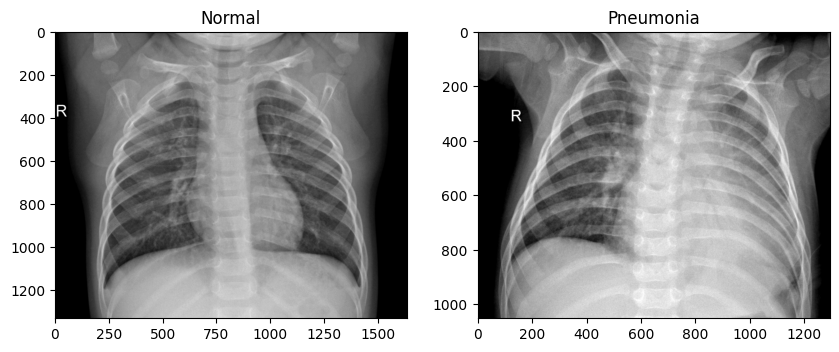

In [77]:
# Both cases are shown in order to observe the differences clearly
train_n = '/content/drive/MyDrive/chest_xray/train/NORMAL/'
train_p = '/content/drive/MyDrive/chest_xray/train/PNEUMONIA/'

# Normal pic
rand_norm = np.random.randint(0, len(os.listdir(train_n)))
norm_pic = os.listdir(train_n)[rand_norm]
norm_pic_address = train_n + norm_pic

# Pneumonia pic
rand_p = np.random.randint(0, len(os.listdir(train_p)))
sic_pic = os.listdir(train_p)[rand_p]
sic_address = train_p + sic_pic

# Load the images and convert to grayscale
norm_load = Image.open(norm_pic_address).convert('L')
sic_load = Image.open(sic_address).convert('L')

# Plot the images
f = plt.figure(figsize=(10, 6))
a1 = f.add_subplot(1, 2, 1)
img_plot = plt.imshow(norm_load, cmap='gray')
a1.set_title('Normal')

a2 = f.add_subplot(1, 2, 2)
img_plot = plt.imshow(sic_load, cmap='gray')
a2.set_title('Pneumonia')

plt.show()

In [78]:
# Data is loaded and formatted to make sure it fits the CNN
def load_images(path, label):
    images = []
    labels = []
    for img_path in glob.glob(path + '/*.jpeg'):
        img = Image.open(img_path).convert('L').resize((32, 32))
        img_array = np.array(img) / 255.0
        images.append(img_array)
        labels.append(label)
    return images, labels

train_n = '/content/drive/MyDrive/chest_xray/train/NORMAL/'
train_p = '/content/drive/MyDrive/chest_xray/train/PNEUMONIA/'

normal_images, normal_labels = load_images(train_n, 0)
pneumonia_images, pneumonia_labels = load_images(train_p, 1)

images = normal_images + pneumonia_images
labels = normal_labels + pneumonia_labels

images = np.array(images)
labels = np.array(labels)
images = images.reshape(-1, 32, 32, 1)

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [79]:
# CNN is developed for this problem in particular
model = tf.keras.models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten_2 (Flatten)         (None, 1024)             

In [80]:
# This callback function serves to end training if desired accuracy is reached
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') >= 0.97):
      print("\nReached 97% accuracy so cancelling training!")
      self.model.stop_training = True

In [81]:
# We import the callback class to instantiate the callback function
callbacks = myCallback()

# The model is compiled in order to start training
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy']
              )
# The data is fitted to the model and training starts
history = model.fit(X_train, y_train, epochs=10, callbacks=[callbacks] ,validation_data=(X_test, y_test))

Epoch 1/10
131/131 [==============================] - 5s 30ms/step - loss: 0.3980 - accuracy: 0.8160 - val_loss: 0.2295 - val_accuracy: 0.8930
Epoch 2/10
131/131 [==============================] - 4s 29ms/step - loss: 0.1736 - accuracy: 0.9307 - val_loss: 0.1460 - val_accuracy: 0.9408
Epoch 3/10
131/131 [==============================] - 5s 41ms/step - loss: 0.1176 - accuracy: 0.9570 - val_loss: 0.1163 - val_accuracy: 0.9542
Epoch 4/10
131/131 [==============================] - 4s 28ms/step - loss: 0.1062 - accuracy: 0.9601 - val_loss: 0.1268 - val_accuracy: 0.9532
Epoch 5/10
131/131 [==============================] - 4s 29ms/step - loss: 0.0815 - accuracy: 0.9685 - val_loss: 0.1839 - val_accuracy: 0.9331
Epoch 6/10
131/131 [==============================] - ETA: 0s - loss: 0.0789 - accuracy: 0.9708
Reached 97% accuracy so cancelling training!
131/131 [==============================] - 5s 38ms/step - loss: 0.0789 - accuracy: 0.9708 - val_loss: 0.1000 - val_accuracy: 0.9570


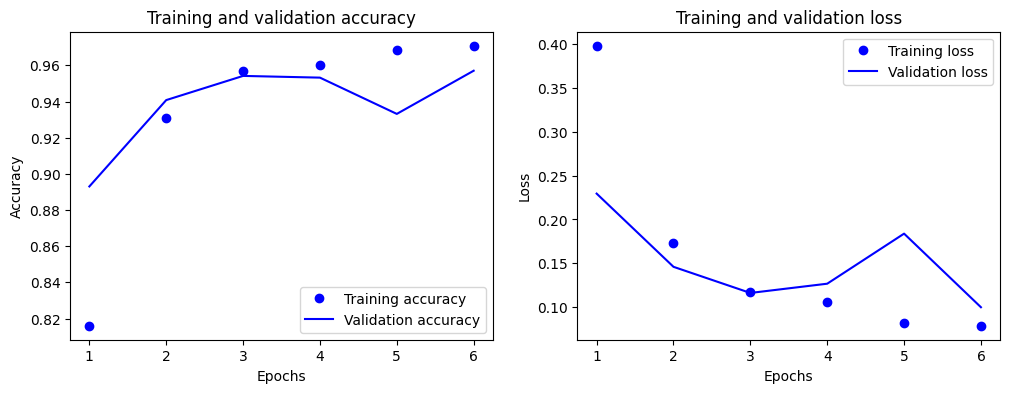

In [86]:
# Function to plot the model's loss and accuracy history to follow patterns that may be useful for insights
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)

In [83]:
# Now we evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc}')

33/33 - 0s - loss: 0.1000 - accuracy: 0.9570 - 242ms/epoch - 7ms/step
Test accuracy: 0.9570200443267822


In [84]:
# Finally, we can make predictions with our model
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

33/33 [==============================] - 0s 8ms/step


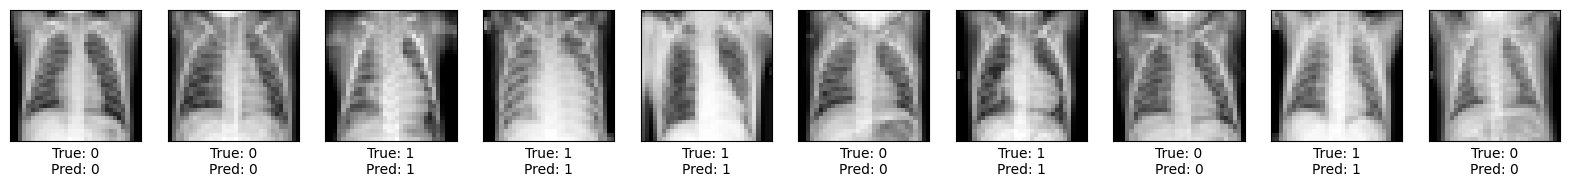

In [87]:
# This function plots the results graphically
def display_predictions(images, true_labels, predicted_labels, num_images=10):
    plt.figure(figsize=(num_images * 2, 3))

    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(f'True: {true_labels[i]}\nPred: {predicted_labels[i]}')

    plt.show()

# We present the results by plotting them
display_predictions(X_test, y_test, predicted_labels)